In [218]:
# Set seed and parameters
library(lfe) # for OLS (easier robust SE)
library(AER) # for IV
set.seed(10)
N <- 50000
options(warn=-1)

In [259]:
##Simulation testing the robustness of IV to low-levels of correlation between the instrument and predictor


cor_vals <- c()
ols_estimates <- c()
iv_estimates <- c()

num_trials <- 10
## smaller noise val reduces correlation between the instrument and predictor
noise_vals <- c(1, 0.4, 0.3, 0.2, 0.1, 0.05, 0.025, 0.0125, 0.00625)

for (noise_val in noise_vals){
    for (trial in 1:num_trials){
        ## Create empty dataframe
        df <- data.frame("ID" = 1:N)

        ## Assign aggressive (arrest) or soft treatment randomly
        df$aggresive <- floor(runif(N, min=0, max=2))

        ## unobserved cofounder
        df$drunkness <- runif(N, min=0, max=1.25)

        ## More likely to be arrested if assigned aggressive, less likely to be arrested arrested in soft
        df$arrest <- as.integer((noise_val*df$aggresive +  df$drunkness >= 0.5))

        ## individual found guilty of DV again
        ## less likely to reoffend if arrested
        ## more likely to reoffend the more drunk
        df$reoffend <- as.integer(((-0.3)*df$arrest + df$drunkness + runif(N, min=0, max=1) >= 0.5)) 
        
        ## get correlation between intstrament and observed variable
        cor_vals <- c(cor_vals, cor(df$aggresive, df$arrest))
        
        ## Regression result
        OLS <- felm(reoffend ~ arrest, data=df)
        ## estimated coefficient of arrest
        ols_estimates <- c(ols_estimates, summary(OLS)$coefficients[2])
        
        ## IV result
        IV = ivreg(reoffend ~ arrest | aggresive, data = df)
        iv_estimates <- c(iv_estimates, summary(IV)$coefficients[2])    
    }
}

In [260]:
## get avg and var of results
avg_cor_vals <- c()
avg_ols_vals <- c()
var_ols_vals <- c()
avg_iv_vals <- c()
var_iv_vals <- c()

n <- length(cor_vals)

split_cor_vals <- split(cor_vals, rep(1:ceiling(n/num_trials), each=num_trials)[1:n])
for(item in split_cor_vals){avg_cor_vals <- c(avg_cor_vals, mean(item))}

split_ols_vals <- split(ols_estimates, rep(1:ceiling(n/num_trials), each=num_trials)[1:n])
for(item in split_ols_vals){avg_ols_vals <- c(avg_ols_vals, mean(item))}
for(item in split_ols_vals){var_ols_vals <- c(var_ols_vals, var(item))}

split_iv_vals <- split(iv_estimates, rep(1:ceiling(n/num_trials), each=num_trials)[1:n])
for(item in split_iv_vals){avg_iv_vals <- c(avg_iv_vals, mean(item))}
for(item in split_iv_vals){var_iv_vals <- c(var_iv_vals, var(item))}

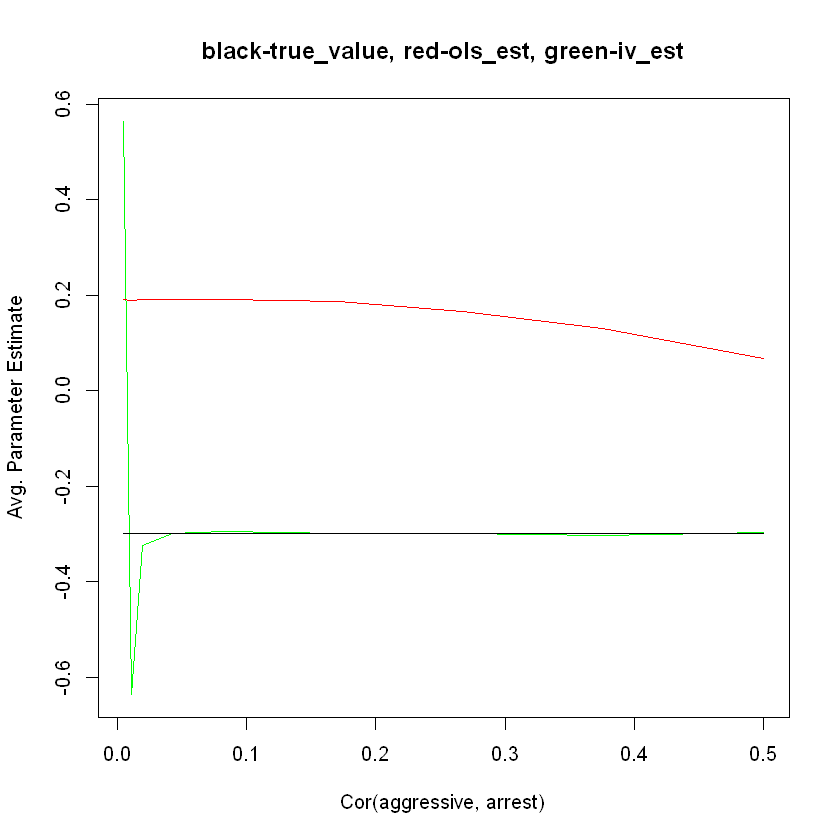

In [272]:
plot(avg_cor_vals, avg_iv_vals, type="l", col='green', ylab = "Avg. Parameter Estimate", xlab = "Cor(aggressive, arrest)", main='black-true_value, red-ols_est, green-iv_est')
lines(avg_cor_vals, avg_ols_vals, col='red')
lines(avg_cor_vals, c(-0.3, -0.3,-0.3, -0.3,-0.3, -0.3,-0.3, -0.3,-0.3), col='black')

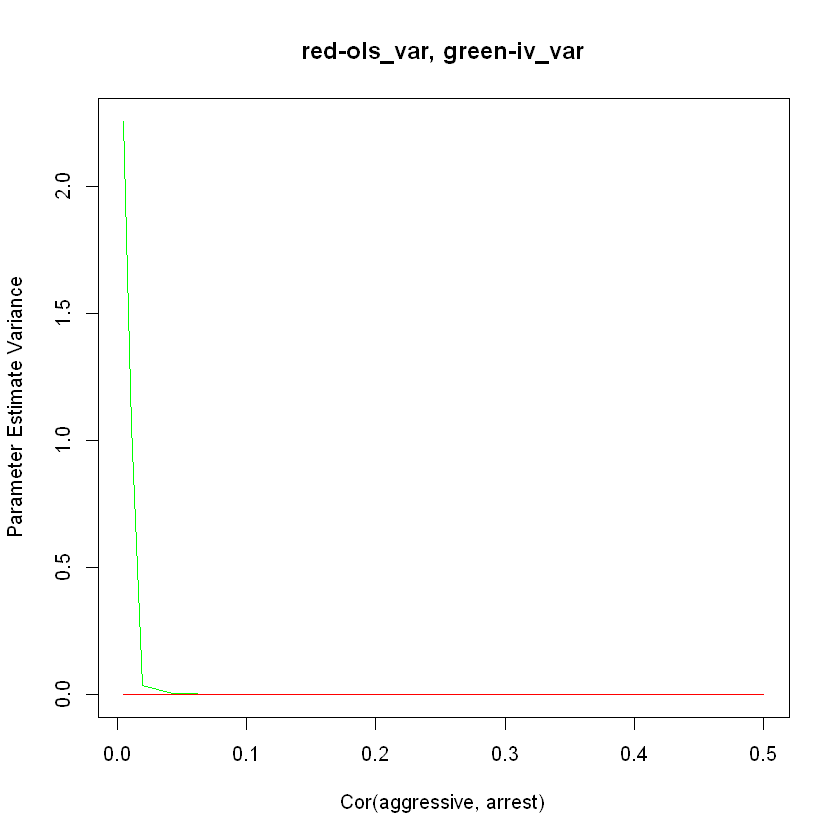

In [271]:
plot(avg_cor_vals, var_iv_vals, type="l", col='green', ylab = "Parameter Estimate Variance", xlab = "Cor(aggressive, arrest)", main='red-ols_var, green-iv_var')
lines(avg_cor_vals, var_ols_vals, col='red')

## I am very surprised that the IV approach seems very robust to small levels of correlation between the instrument and predictor. Maybe I am doing something wrong but this should be violating one of the assumptions.